In [1]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
#https://www.kaggle.com/datasets/chancev/carsforsale
def load_car_data():
    csv_path = os.path.join('Datasets', 'cars_raw.csv')
    return pd.read_csv(csv_path)

In [3]:
# Clean Make column
def clean_make(df):
    df['Make'] = df['Make'].astype('category')

# Clean certified column    
def clean_certified(df):
    df.loc[data['Used/New'].str.contains('Certified'), 'Used/New'] = 'Certified'
    df.astype('category')
    
# Clean Price column
def clean_price(df):   
    df.drop(df.index[df['Price'] == 'Not Priced'], inplace = True)
    df['Price'] = df['Price'].str.replace(r'\D','', regex=True).astype('int32')
    
# Clean State column [Not outputting the correct cleaned dataframe for some reason?]
def clean_state(df):
    invalid_state = ['Bldg','US-169','SE','Glens','US-12','Suite','AZ-101']
    df = df[~df['State'].isin(invalid_state)]
    df.loc[df['State'] == 'Michigan', 'State'] = 'MI'

# Clean zipcode column
# This actually isn't correct, writes in missing for every digit instead of single time
def clean_zipcode(df):
    df['Zipcode'] = df['Zipcode'].str.replace(r'\D','Missing', regex=True).astype('str')
    
# clean drivetrain column
def clean_drivetrain(df):
    drivetrain_dict = {'All-wheel Drive':'AWD', 'Front-wheel Drive':'FWD', 'Front Wheel Drive':'FWD',
                  'Four-wheel Drive':'4WD', 'Rear-wheel Drive':'RWD'}
    df['Drivetrain'] = df['Drivetrain'].replace(drivetrain_dict)
    df['Drivetrain'] = df['Drivetrain'].str.replace('[^a-zA-Z0-9]', '?', regex=True).str.strip()
    df.drop(df[df['Drivetrain']=='?'].index, inplace=True)

# clean fuel type   
def clean_fuel_type(df):
    df['FuelType'] = df['FuelType'].apply(lambda x: 'Not Gasoline' if 'Gasoline' not in x else 'Gasoline')
    
# clean transmission   
def clean_fuel_type(df):
    df['Transmission'] = df['Transmission'].apply(lambda x: 'Automatic' if 'utomatic' in x else
                    ('Manual' if 'anual' in x else 'Other'))
    
# drop useless columns
def drop_useless_columns(df):
    drop_list = ['MaxMPG','SellerReviews','ComfortRating','ExteriorStylingRating','PerformanceRating','SellerRating',
                 'SellerName','MinMPG','InteriorDesignRating', 
                 'StreetName', 'Engine', 'VIN', 'Stock#','State','Zipcode']
    df.drop(drop_list, axis=1, inplace=True)

In [4]:
def clean_data(data, label): 
    clean_make(data)
    clean_certified(data)
    #clean_price(label)
    #clean_state(data)
    #clean_zipcode(data)
    #clean_drivetrain(data)    
    clean_fuel_type(data)

In [5]:
data = load_car_data()

drop_useless_columns(data)
# cleaning price drops rows so I need to do it before splitting data
clean_price(data)
# drivetrain drops rows so I need to do it before splitting data
clean_drivetrain(data)

In [6]:
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 1)

In [7]:
# Revert to a clean training set
cars = train_set.drop('Price', axis=1)
cars_labels = train_set['Price'].copy()

In [8]:
# Clean missing data
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# Median can only be computed on numericals so creaty a copy with only numerical fields
drop_list = ['Make','Model','Used/New','SellerType','DealType','ExteriorColor',
             'InteriorColor','Drivetrain','FuelType','Transmission']
cars_num = cars.drop(drop_list, axis=1)

# This computer
imputer.fit(cars_num)

SimpleImputer(strategy='median')

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('cleaner', clean_data(cars, cars_labels)),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

In [10]:
#OneHotEncoder will make a column for each attribute and set to 1(hot) or 0(cold)
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

cars_cat = cars[['Make','SellerType','DealType','FuelType','Used/New','Transmission']]
cars_cat_1hot = cat_encoder.fit_transform(cars_cat)
# As you can see it returns as dtype 'sparse matrix' which can be converted to
# a NumPy array with toarray()

In [11]:
from sklearn.compose import ColumnTransformer

num_attribs = list(cars_num)
cat_attribs = list(cars_cat)

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

data_prepared = full_pipeline.fit_transform(cars)

In [12]:
# Now train the model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(data_prepared, cars_labels)

LinearRegression()

In [13]:
# Testing the model on some data
some_data = cars.iloc[:5]
some_labels = cars_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

Predictions: [33643.91418256 41716.86312444 69776.6722597  44712.21466309
 47275.18247045]
Labels: [45241, 24333, 39900, 40995, 41985]


In [14]:
# Measure the models RMSE (not very good, underfit model)
from sklearn.metrics import mean_squared_error
car_predictions = lin_reg.predict(data_prepared)
lin_mse = mean_squared_error(cars_labels, car_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_mse

174178818.88629764

In [15]:
# Try using a Random Forest Regresso
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(data_prepared, cars_labels)

RandomForestRegressor()

In [16]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard Deviation: {scores.std()}')

In [17]:
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(forest_reg, data_prepared, cars_labels,
                            scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores= np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 5764.25987209  7919.01459013  7305.79077096  7740.97440777
 10364.17302222 12489.26116129  7839.03116971  6403.23090773
  6729.17141257  9567.21016115]
Mean: 8212.211747562473
Standard Deviation: 1936.3184229012538


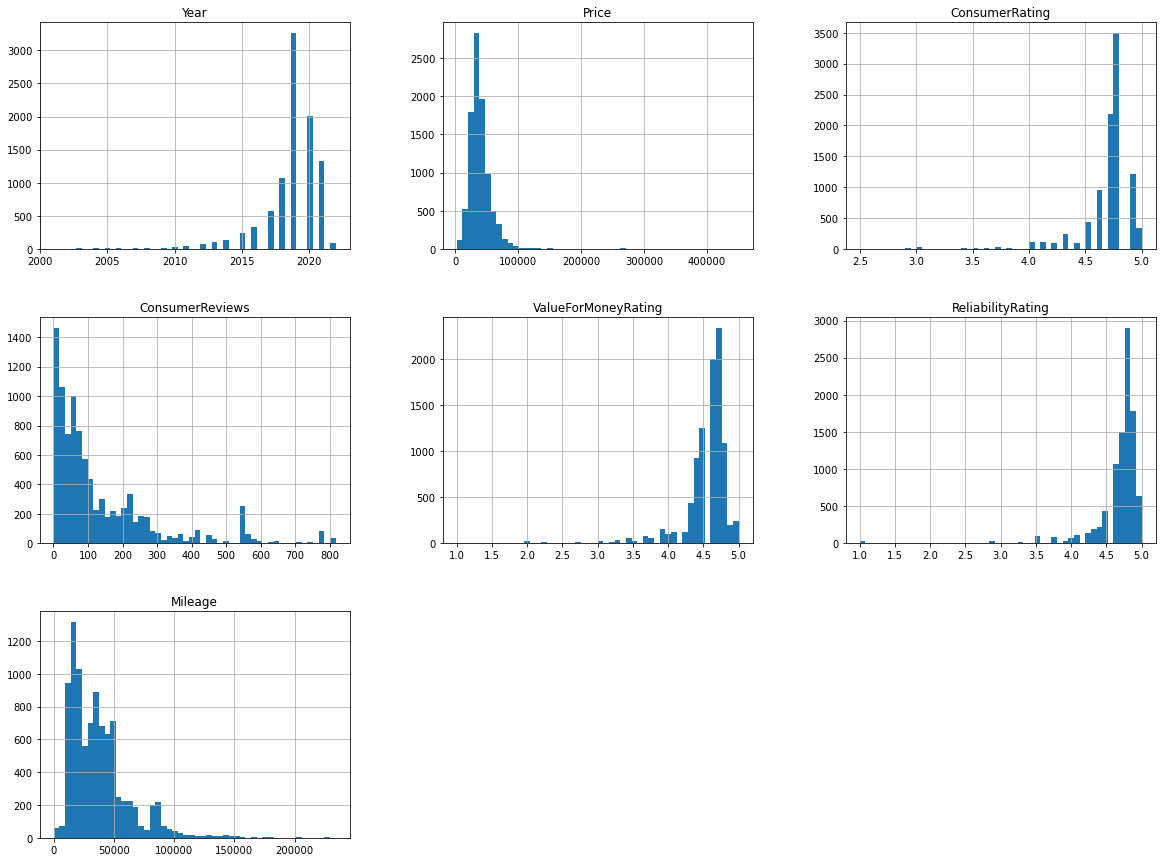

In [18]:
data.hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:>

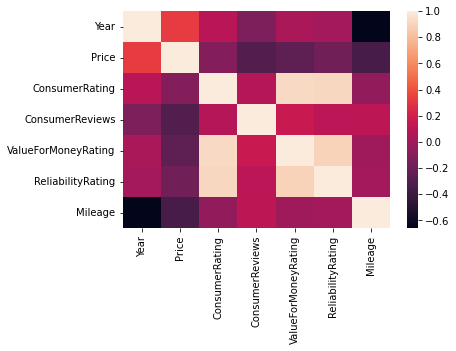

In [19]:
#calculate correlation between attributes
import seaborn as sns
corr_matrix = data.corr()
sns.heatmap(corr_matrix)

In [20]:
corr_matrix['Price'].sort_values(ascending=False)

Price                  1.000000
Year                   0.323911
ConsumerRating        -0.107844
ReliabilityRating     -0.175229
ValueForMoneyRating   -0.253086
ConsumerReviews       -0.305777
Mileage               -0.346016
Name: Price, dtype: float64